<a href="https://colab.research.google.com/github/dfridland/PyTorch/blob/HW8/PyTorchLesson8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#metric learning

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset =  datasets.MNIST(
    '.',
    train=True,
    download = True, 
    transform=transform
)


 Distance between classes in pixels 3 and 1
0.08597984164953232


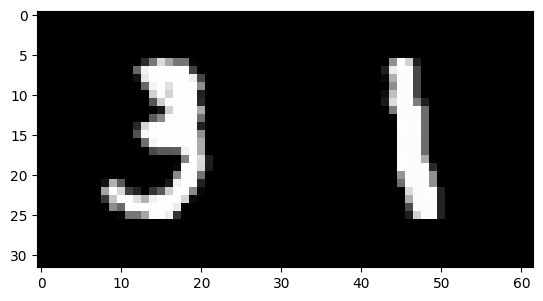

In [ ]:
img_1, label_1 = dataset[10]
img_2, label_2 = dataset[6]

print(f' Distance between classes in pixels {label_1} and {label_2}')
print(torch.mean(torch.square(img_1 - img_2)).item())

grid = torchvision.utils.make_grid([img_1, img_2])
plt.imshow(grid.permute(1,2,0));                 


 Distance between classes in pixels 3 and 3
0.11974499374628067


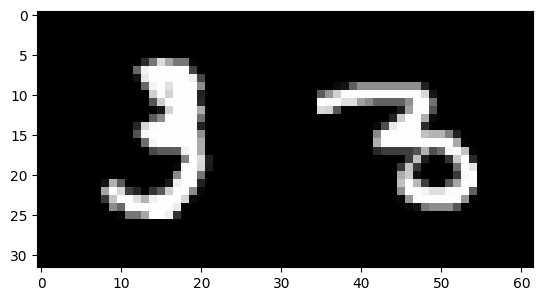

In [ ]:
img_3, label_3 = dataset[30]

print(f' Distance between classes in pixels {label_1} and {label_3}')
print(torch.mean(torch.square(img_1 - img_3)).item())

grid = torchvision.utils.make_grid([img_1, img_3])
plt.imshow(grid.permute(1,2,0));   

In [ ]:
class TinyModel(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=4,
                           out_channels=8,
                           kernel_size=3)
    self.fc1= nn.Linear(in_features=200,
                        out_features=128) 
    self.fc2= nn.Linear(in_features=128,
                        out_features=num_classes)
    
  def forward(self, x):
      x = self.conv1(x)
      x = self.pool(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.pool(x)
      x = self.relu(x)
      x = x.reshape((-1, 200))
      emb = self.fc1(x)
      x = self.fc2(emb)
      return x, emb

In [ ]:
def train(model, dataloader):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  model.to(device)
  for step, (imgs, labels) in enumerate(dataloader):
    imgs, labels = imgs.to(device), labels.to(device)
    pred, _ = model(imgs)
    loss = criterion(pred, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
      print(f'Loss is {loss.item()}')
  return model  

In [ ]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True
)

In [ ]:
model = TinyModel(10)
model = train(model, dataloader)

Loss is 2.3096086978912354
Loss is 0.3321482837200165
Loss is 0.19944757223129272


In [ ]:
model.to('cpu')
_, emb_1 = model(img_1[None])
_, emb_2 = model(img_2[None])
_, emb_3 = model(img_3[None])

In [ ]:
print(f'The distance between classes {label_1} and {label_2}')
print(torch.mean(torch.square(emb_1 - emb_2)). item())

print(f'The distance between classes {label_1} and {label_3}')
print(torch.mean(torch.square(emb_1 - emb_3)). item())

The distance between classes 3 and 1
0.9943320155143738
The distance between classes 3 and 3
0.8365541100502014


In [ ]:
# TripletMarginLoss

In [ ]:
anchor = torch.randn(1, 3, requires_grad = True)
positive = torch.randn(1, 3, requires_grad = True)
negative = torch.randn(1, 3, requires_grad = True)

triplet_margin_loss = nn.TripletMarginLoss(margin=1.0)
output = triplet_margin_loss(anchor, positive, negative)

print('anchor:', anchor)
print('positive:', positive)
print('negative', negative)
print('output', output)

anchor: tensor([[ 0.0442, -1.5424,  0.3290]], requires_grad=True)
positive: tensor([[-0.3035,  0.0501, -1.5472]], requires_grad=True)
negative tensor([[ 0.2081, -0.2203,  1.4714]], requires_grad=True)
output tensor(1.7305, grad_fn=<MeanBackward0>)


In [ ]:
torch.mean(torch.square(anchor - positive))

tensor(2.0591, grad_fn=<MeanBackward0>)

In [ ]:
torch.mean(torch.square(anchor - negative))

tensor(1.0266, grad_fn=<MeanBackward0>)

In [ ]:
#Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Encoder(nn.Module):
  def __init__(self, latent_dims):
    super(Encoder, self).__init__()
    self.linear1 = nn.Linear(784, 512)
    self.linear2 = nn.Linear(512, latent_dims)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear1(x))
    return self.linear2(x)
    



In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_dims):
    super(Decoder, self).__init__()
    self.linear1 = nn.Linear(latent_dims, 512)
    self.linear2 = nn.Linear(512, 784)
  def forward(self, z):
    z = F.relu(self.linear1(z))
    z = torch.sigmoid(self.linear2(z))
    return z.reshape((-1, 1, 28, 28))

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self, latent_dims):
    super(Autoencoder, self).__init__()
    self.encoder =  Encoder(latent_dims)
    self.decoder =  Decoder(latent_dims)
  
  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)



In [ ]:
def train(autoencoder, data, epochs=10):
  opt = torch.optim.Adam(autoencoder.parameters())

  for epoch in range(epochs):
    for step, (x, _) in enumerate(data):
      x = x.to(device)
      opt.zero_grad()
      x_hat = autoencoder(x)
      loss = ((x - x_hat) **2).sum()
      loss.backward()
      opt.step()
      
      if step % 200 == 0:
        print(f'Epoch[{epoch + 1}/{epochs}]. Step [{step}/{len(data)}]. Loss is {loss.item():.2f}')
  return autoencoder

In [ ]:
latent_dims=2
autoencoder = Autoencoder(latent_dims).to(device)

data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', 
                               transform=torchvision.transforms.ToTensor(), 
                               download=True),
                               batch_size=256,
                               shuffle=True) 

In [ ]:
%time 
autoencoder = train(autoencoder, data)


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
Epoch[1/10]. Step [0/235]. Loss is 46823.09
Epoch[1/10]. Step [200/235]. Loss is 10632.40
Epoch[2/10]. Step [0/235]. Loss is 10066.93
Epoch[2/10]. Step [200/235]. Loss is 9950.73
Epoch[3/10]. Step [0/235]. Loss is 10010.01
Epoch[3/10]. Step [200/235]. Loss is 9217.85
Epoch[4/10]. Step [0/235]. Loss is 9557.47
Epoch[4/10]. Step [200/235]. Loss is 9107.65
Epoch[5/10]. Step [0/235]. Loss is 8938.02
Epoch[5/10]. Step [200/235]. Loss is 9058.94
Epoch[6/10]. Step [0/235]. Loss is 9273.80
Epoch[6/10]. Step [200/235]. Loss is 8630.85
Epoch[7/10]. Step [0/235]. Loss is 9130.07
Epoch[7/10]. Step [200/235]. Loss is 8386.28
Epoch[8/10]. Step [0/235]. Loss is 8749.28
Epoch[8/10]. Step [200/235]. Loss is 8853.87
Epoch[9/10]. Step [0/235]. Loss is 8901.54
Epoch[9/10]. Step [200/235]. Loss is 8607.83
Epoch[10/10]. Step [0/235]. Loss is 8551.07
Epoch[10/10]. Step [200/235]. Loss is 8496.33


In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
  plt.figure(figsize=(10, 8))
  for i,(x,y) in enumerate(data):
    z = autoencoder.encoder(x.to(device))
    z = z.to('cpu').detach().numpy()
    plt.scatter(z[:,0], z[:, 1], c=y, cmap='tab10')
    if i > num_batches:
      plt.colorbar()
      break

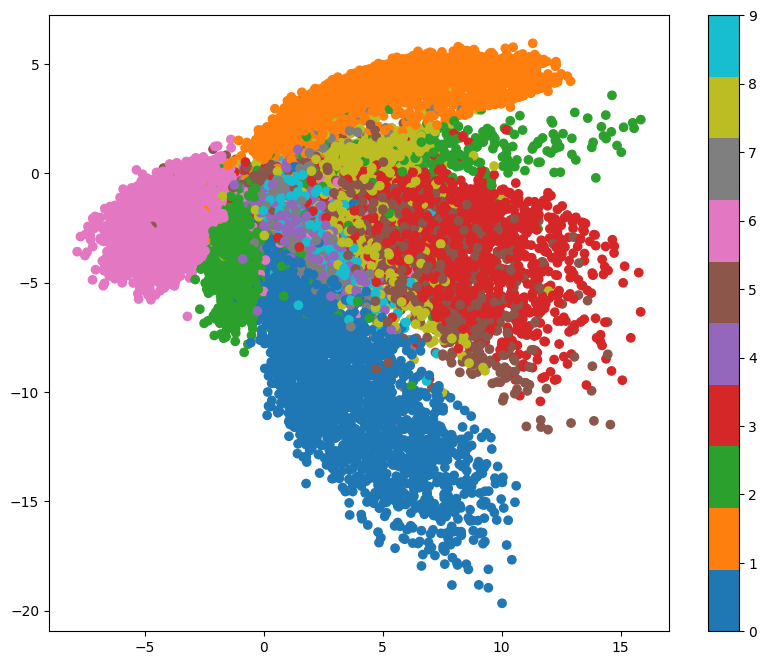

In [ ]:
plot_latent(autoencoder, data)

In [ ]:
def plot_reconsctructed(autoencoder, r0=(-3,3), r1=(-3,3), n=12):
  w= 28

  img = np.zeros((n*w, n*w))
  for i, y in enumerate(np.linspace(*r1, n)):
    for j, x in enumerate(np.linspace(*r0, n)):
      z = torch.Tensor([[x, y]]).to(device)
      x_hat = autoencoder.decoder(z)
      x_hat = x_hat.reshape(28,28).to('cpu').detach().numpy()
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat

  plt.figure(figsize=(15,6))
  plt.imshow(img, extent=[*r0, *r1])

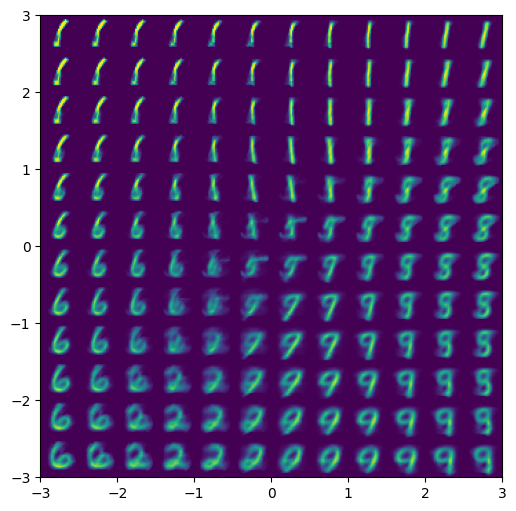

In [ ]:
plot_reconsctructed(autoencoder)

In [ ]:
#Variational Autoencoder(VAE)